In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from mlresearch.utils import set_matplotlib_style
from recgame.environments._cda_environment import CDAEnvironment
from recgame.data_augmentation import CDA
from functions import (
    fairness_metrics_viz_data, 
    biased_data_generator_hc, 
    get_scaler_hc, 
    fairness_metrics_overall, 
    fairness_metrics_overall_visualizations, 
    fairness_metrics_per_time_step, 
    fairness_metrics_viz_data,
    IgnoreGroupRanker,
    IgnoreGroupLR
)


In [2]:
set_matplotlib_style(16)

# Some variables to define the problem
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED+1)
N_CONTINUOUS = 2
N_CAT = 0
N_AGENTS = 100
BIAS_FACTOR = 2

# Environment variables
N_LOANS = 10  # np.array([20, 1, 10, 30, 0, 5, 50, 10, 40])
ADAPTATION = .1  # np.array([.2, .1, .3, .25, .1, .4, .05, .05, .2])
NEW_AGENTS = 10  # np.array([40, 10, 50, 5, 0, 100, 0, 0, 20])

# NFeatureRecourse ignoring categorical feature

In [3]:
import warnings
from typing import Union
import numpy as np
from recgame.recourse.base import BaseRecourse


class NFeatureRecourse(BaseRecourse):
    """TODO: Add documentation."""

    def __init__(
        self,
        model,
        n_features: int = None,
        threshold=0.5,
        categorical: Union[list, np.ndarray] = None,
        immutable: Union[list, np.ndarray] = None,
        step_direction: dict = None,
        y_desired: Union[int, str] = 1,
    ):
        super().__init__(
            model=model,
            threshold=threshold,
            categorical=categorical,
            immutable=immutable,
            step_direction=step_direction,
            y_desired=y_desired,
        )

        # if categorical is not None and categorical != []:
        #     raise TypeError(
        #         "NFeatureRecourse does not work with categorical features. Consider "
        #         "using a different recourse method."
        #     )

        self.n_features = n_features

    def _counterfactual(self, agent, action_set):
        agent_original = agent.copy()

        # Do not change if the agent is over the threshold
        if self.model.predict_proba(agent.to_frame().T)[0, -1] >= self.threshold:
            return agent_original

        categorical_vals = agent_original[self.categorical].values
        agent = agent_original.drop(self.categorical).copy()

        intercept, coefficients, model = self._get_coefficients()

        # Get base vector
        base_vector = coefficients.copy().squeeze()
        n_features = (
            base_vector.shape[0] if self.n_features is None else self.n_features
        )

        is_usable = np.array(
            [
                action_set[col].step_direction in [np.sign(coeff), 0]
                and action_set[col].actionable
                for col, coeff in zip(agent.index, base_vector)
            ]
        )
        base_vector[~is_usable] = 0

        # Use features with highest contribution towards the threshold
        rejected_features = np.argsort(np.abs(base_vector))[:-n_features]
        base_vector[rejected_features] = 0

        base_vector = base_vector / np.linalg.norm(base_vector)
        multiplier = (-intercept - np.dot(agent.values, coefficients.T)) / np.dot(
            base_vector, coefficients.T
        )
        counterfactual = agent + multiplier * base_vector
                        
        lb, ub = np.array(action_set.lb), np.array(action_set.ub)
        
        lb = lb[action_set.df.name.values != self.categorical]
        ub = ub[action_set.df.name.values != self.categorical]

        # Check if base_vector adjustments are not generating invalid counterfactuals
        for i in range(agent.shape[0]):
            # Adjust vector according to features' bounds
            lb_valid = counterfactual >= lb
            ub_valid = counterfactual <= ub

            if lb_valid.all() and ub_valid.all():
                break

            if not lb_valid.all():
                # Fix values to its lower bound
                idx = np.where(~lb_valid)[0]
                agent[idx] = lb[idx]
                base_vector[idx] = 0

            if not ub_valid.all():
                # Fix values to its upper bound
                idx = np.where(~ub_valid)[0]
                agent[idx] = ub[idx]
                base_vector[idx] = 0

            if (base_vector == 0).all():
                # All max/min boundaries have been met.
                counterfactual = agent
            else:
                
                # Redefine counterfactual after adjusting the base vector
                base_vector = base_vector / np.linalg.norm(base_vector)
                multiplier = (
                    -intercept - np.dot(agent.values, coefficients.T)
                ) / np.dot(base_vector, coefficients.T)
                counterfactual = agent + multiplier * base_vector

        lb_valid = counterfactual >= lb
        ub_valid = counterfactual <= ub
        if not (lb_valid.all() and ub_valid.all()):
            warnings.warn(
                "Could not generate a counterfactual to reach the desired threshold."
            )

            
        for cat_feat, value in zip(self.categorical, categorical_vals):
            counterfactual[cat_feat] = value


        return counterfactual


# Define functions

In [4]:
def env_biased_data_generator(n_agents):
    return biased_data_generator_hc(n_agents, n_continuous=N_CONTINUOUS, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng, N_LOANS=N_LOANS, N_AGENTS=N_AGENTS)

In [5]:
from recgame.environments._behavior_functions import ContinuousFlexible


class ContinuousConstantCustom(ContinuousFlexible):
    """Applies continuous adaptation with constant effort."""
    bias_factor_effort_g0 = 0
    bias_factor_effort_g1 = 0
    
    def effort(self, X, global_adaptation):
        """
        Applies constant effort.

        Returns effort rate.
        """
        # Fetch environment variables
        rng = self.environment._rng

        current_effort = (
            self.environment.effort_ if hasattr(self.environment, "effort_") else None
        )

        df_new = (
            self.environment._new_agents
            if hasattr(self.environment, "_new_agents")
            else X
        )

        counts = Counter(df_new["groups"])
        
        x0 = np.abs(rng.normal(0+self.bias_factor_effort_g0, 1, counts[0]))
        x1 = np.abs(rng.normal(0+self.bias_factor_effort_g1, 1, counts[1]))
        
        x = df_new["groups"].copy()
        x.loc[x==0] = x0
        x.loc[x==1] = x1
        x = x.values

        effort_rate = x * global_adaptation / 20
        effort_rate = pd.Series(effort_rate, index=df_new.index)
        effort_rate = pd.concat([current_effort, effort_rate])

        # return pd.Series(effort_rate, index=X.index)
        return effort_rate

    
def behavior_function_generator(bias_factor_effort_g0, bias_factor_effort_g1):
    behav = ContinuousConstantCustom
    behav.bias_factor_effort_g0 = bias_factor_effort_g0
    behav.bias_factor_effort_g1 = bias_factor_effort_g1
    return behav

# CDA experiment

In [6]:
scaler = get_scaler_hc(
    n_agents=10_000, 
    bias_factor=BIAS_FACTOR, 
    random_state=rng,
    N_AGENTS=N_AGENTS, 
    N_LOANS=N_LOANS
)

In [7]:
df = biased_data_generator_hc(
    N_AGENTS, 
    n_continuous=N_CONTINUOUS, 
    bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng, N_LOANS=N_LOANS, N_AGENTS=N_AGENTS
)
categorical = ["groups"]

model = IgnoreGroupLR(ignore_feature=categorical, random_state=RNG_SEED)
y = IgnoreGroupRanker(np.array([[.5, .5]]), ignore_feature=categorical).predict(df)

model.fit(df, y)

IgnoreGroupLR(ignore_feature=['groups'])

# Environment experiment

In [8]:
# Define the necessary components to run simulation
recourse = NFeatureRecourse(model, categorical=["groups"], immutable=["groups"])# , random_state=RNG_SEED)
recourse.set_actions(df)
recourse.action_set_.lb = [-0.1, -0.1, 0]
recourse.action_set_.ub = [1.1, 1.1, 1]

environment = CDAEnvironment(
    X=df,
    recourse=recourse,
    data_source_func=env_biased_data_generator,
    threshold=N_LOANS,
    threshold_type="absolute",
    adaptation=ADAPTATION,
    behavior_function="continuous_constant",
    growth_rate=NEW_AGENTS,
    growth_rate_type="absolute",
    random_state=RNG_SEED,
)

environment.simulate(20)

CDAEnvironment(X=          f0        f1  groups
0   0.768427  0.471306     1.0
1   0.860178  0.597270     1.0
2   0.752535  0.474958     1.0
3   0.763820  0.565340     1.0
4   0.849140  0.508249     1.0
..       ...       ...     ...
95  0.152917  0.385779     0.0
96  0.292579  0.644092     0.0
97  0.170202  0.755729     0.0
98  0.142021  0.414310     0.0
99  0.344151  0.080369     0.0

[100 rows x 3 columns],
               adaptation=0.1, behavior_function='continuous_constant',
               data_source_func=<function env_biased_data_generator at 0x7f46ec93cee0>,
               growth_rate=10, growth_rate_type='absolute', random_state=42,
               recourse=NFeatureRecourse(categorical=['groups'],
                                         immutable=['groups'],
                                         model=IgnoreGroupLR(ignore_feature=['groups']),
                                         threshold=0.6296724650017026),
               threshold=10)

In [9]:
environment.X_, environment.outcome_

from collections import Counter
Counter(environment.outcome_)

Counter({0: 90, 1: 10})

<Axes: title={'center': 'Population scores over 21 time steps'}, xlabel='Step', ylabel='Score'>

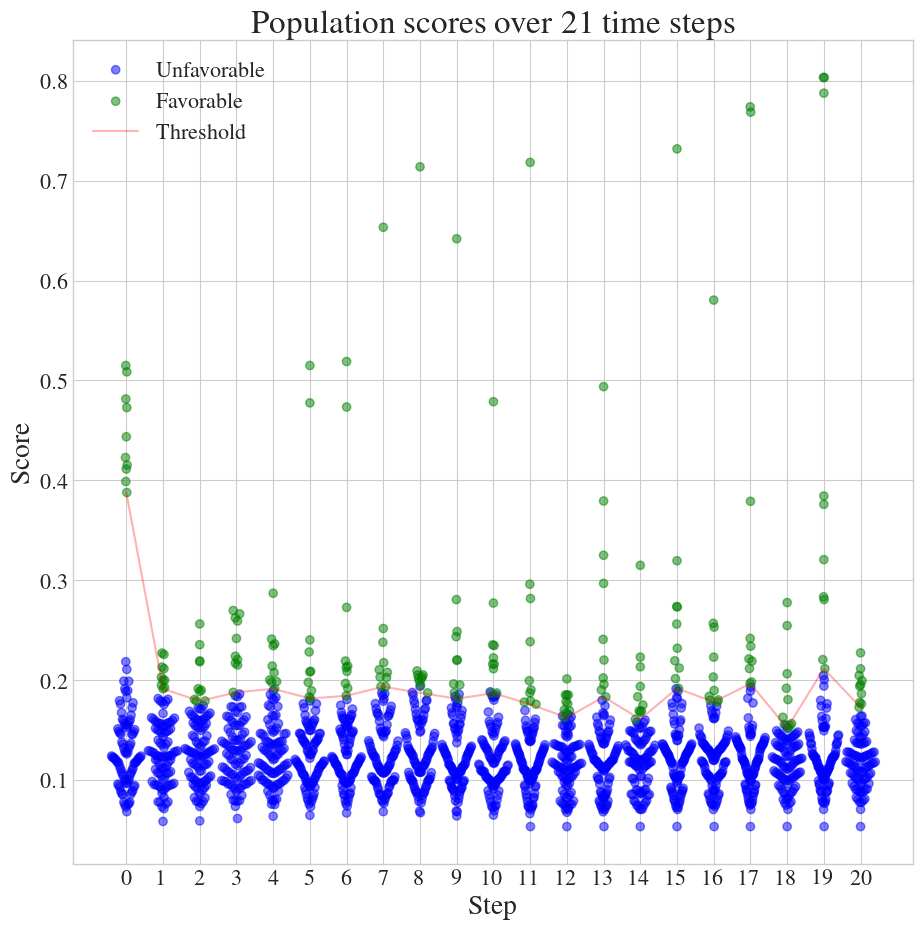

In [10]:
environment.plot.agent_scores(ref_model_step=0)

<Axes: title={'center': 'Population at t=7'}, xlabel='Component 1', ylabel='Component 2'>

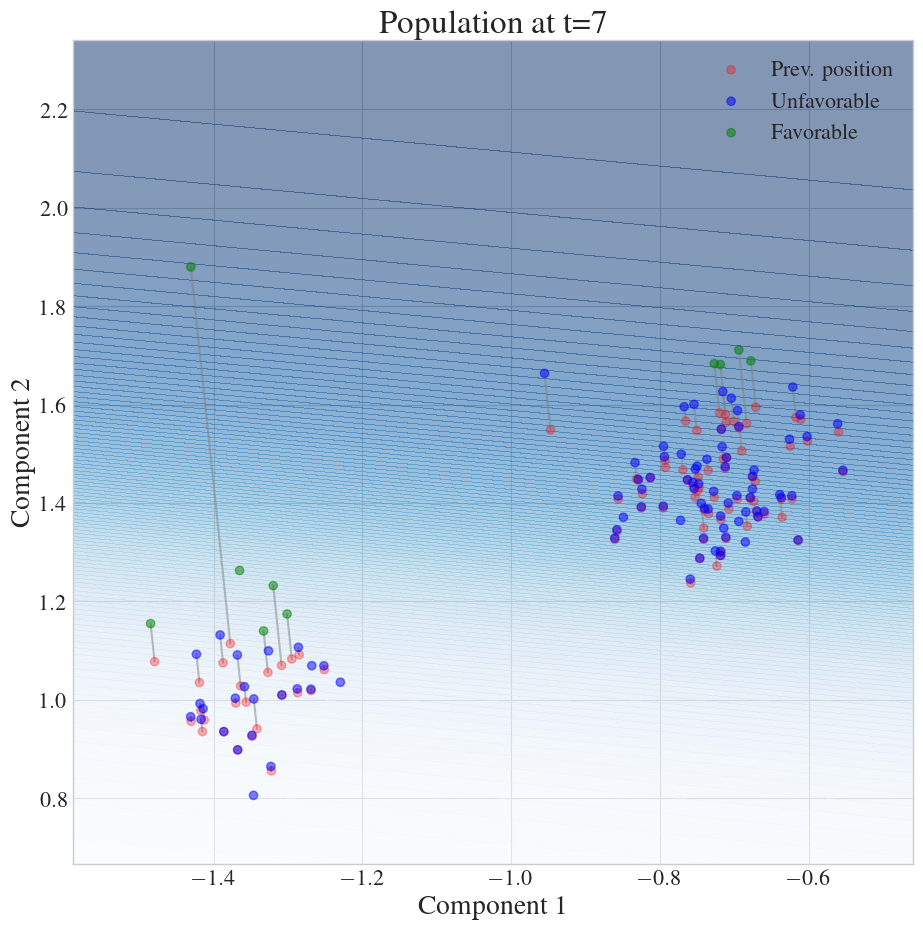

In [11]:
environment.plot.scatter(7)

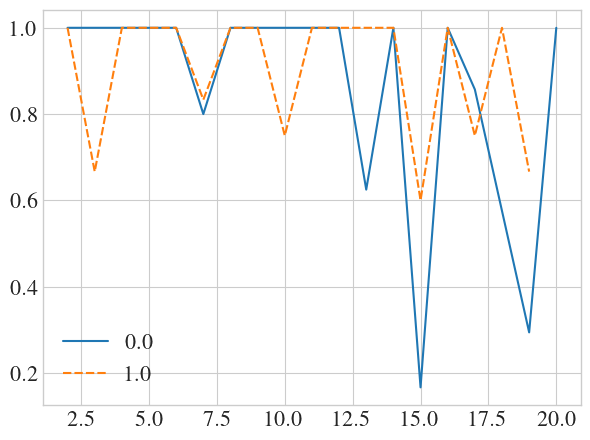

In [12]:
fairness_metrics_per_time_step(environment)

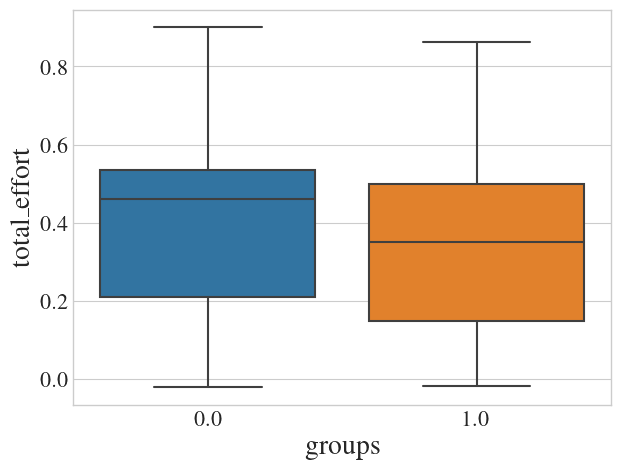

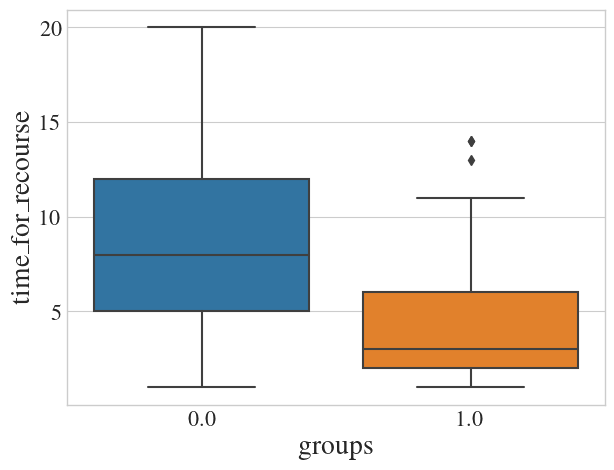

{'etr_disparity': 1.3104168229399225, 'disparate_ttr': 4.239658212396582}

In [13]:
fairness_metrics_overall_visualizations(environment)
# Boxplots for different qualification values

In [14]:
fairness_metrics_viz_data(environment)

,entered_step,n_adaptations,favorable_step,original_score,final_score,n_failures,groups,time_for_recourse,total_effort
5,0,3,4.0,0.145896,0.762959,1,1.0,4.0,0.617063
6,0,2,2.0,0.167420,0.564432,0,1.0,2.0,0.397011
7,0,1,1.0,0.218428,0.225636,0,1.0,1.0,0.007208
8,0,6,6.0,0.154100,0.914923,0,1.0,6.0,0.760823
9,0,6,6.0,0.147236,0.655313,0,1.0,6.0,0.508076
...,...,...,...,...,...,...,...,...,...
264,17,1,18.0,0.479841,0.497864,0,1.0,1.0,0.018023
273,18,1,19.0,0.438930,0.735153,0,1.0,1.0,0.296223
279,18,2,20.0,0.382434,0.531281,1,0.0,2.0,0.148847
284,19,1,20.0,0.625731,0.614021,0,1.0,1.0,-0.011710


# Analysis

In [15]:
steps_info = environment.analysis.steps_info()
steps_info

/home/joaofonseca/miniconda3/envs/recourse-game/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2259: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


,n_adapted,n_candidates,favorable_outcomes,success_rate,threshold,threshold_drift,new_agents,new_agents_proba,moving_agent_proba,success_proba
1,90.0,0.0,10.0,NaN,0.594173,0.532280,10.0,0.0,0.000000e+00,NaN
2,90.0,3.0,10.0,1.000000,0.573572,-0.034672,10.0,0.0,1.763754e-04,0.999976
3,90.0,12.0,10.0,0.750000,0.585622,0.021008,10.0,0.0,1.507469e-10,1.000000
4,89.0,9.0,10.0,1.000000,0.598735,0.022393,10.0,0.0,1.623106e-03,0.966039
5,90.0,7.0,10.0,1.000000,0.583483,-0.025474,10.0,0.0,3.365532e-03,0.960034
6,90.0,9.0,10.0,1.000000,0.585016,0.002627,10.0,0.0,3.345233e-03,0.959621
7,90.0,11.0,10.0,0.818182,0.600426,0.026340,10.0,0.0,1.083862e-02,1.000000
8,90.0,7.0,10.0,1.000000,0.594767,-0.009423,10.0,0.0,1.135222e-02,0.989194
9,90.0,8.0,10.0,1.000000,0.587457,-0.012292,10.0,0.0,4.735291e-12,1.000000
10,90.0,9.0,10.0,0.888889,0.595251,0.013269,10.0,0.0,1.436843e-03,0.968530


In [16]:
(1 - steps_info["success_rate"]) * steps_info["n_candidates"], ((1 - steps_info["success_rate"]) * steps_info["n_candidates"]).sum()

(1      NaN
 2      0.0
 3      3.0
 4      0.0
 5      0.0
 6      0.0
 7      2.0
 8      0.0
 9      0.0
 10     1.0
 11     0.0
 12     0.0
 13     3.0
 14     0.0
 15     9.0
 16     0.0
 17     2.0
 18     0.0
 19    14.0
 20     0.0
 dtype: float64,
 34.0)

In [17]:
from collections import Counter
Counter(environment.analysis.agents_info().n_failures), environment.analysis.agents_info().n_failures.sum()


(Counter({0: 266, 1: 34}), 34)

In [18]:
environment.analysis.agents_info()

,entered_step,n_adaptations,favorable_step,original_score,final_score,n_failures
0,0,0,0.0,0.398779,0.398779,0
1,0,0,0.0,0.508522,0.508522,0
2,0,0,0.0,0.387770,0.387770,0
3,0,0,0.0,0.422818,0.422818,0
4,0,0,0.0,0.472789,0.472789,0
...,...,...,...,...,...,...
295,20,0,NaN,0.237770,NaN,0
296,20,0,NaN,0.313689,NaN,0
297,20,0,NaN,0.398987,NaN,0
298,20,0,NaN,0.253496,NaN,0


[[3.18189278 1.2122726 ]] [-3.42695834]


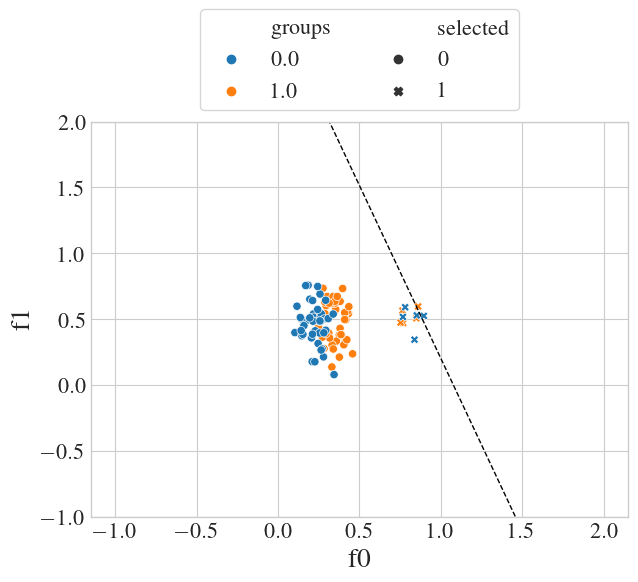

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

time_step = 0
clf = environment.metadata_[time_step]["model"]
print(clf.coef_, clf.intercept_)
df = environment.metadata_[time_step]["X"]
df["selected"] = environment.metadata_[time_step]["outcome"]

# Retrieve the model parameters
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary
xmin, xmax = -1, 2
ymin, ymax = -1, 2
xd = np.array([xmin, xmax])
yd = m*xd + c
ax = sns.scatterplot(data=df, x="f0",y="f1",hue="groups" ,style="selected")
ax.set(ylim=(ymin, ymax))
plt.plot(xd, yd, 'k', lw=1, ls='--')
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=2, title=None, frameon=True,
)